In [229]:
import numpy as np
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper,BravyiKitaevMapper
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter, QuantumRegister

In [230]:
n = 2
N = 2*n
t=1
mu=1.5
U=3

In [231]:
op = FermionicOp(
    {
        "+_0 -_0": 1.0,
        "+_1 -_1": -1.0,
    },
    num_spin_orbitals=2,
)

In [232]:
print(op)

Fermionic Operator
number spin orbitals=2, number terms=2
  1.0 * ( +_0 -_0 )
+ -1.0 * ( +_1 -_1 )


In [233]:
def qOp(i,j):
    return FermionicOp(
    {
        "+_{i} -_{j}".format(i=i%N,j=j%N): 1.0,
    },
    num_spin_orbitals=N,
)

In [234]:
t_list = []
U_list = []
for i in range(n):
    t_list.append((2*i,(2*i+2)%N))
    t_list.append((2*i+1,(2*i+3)%N))
site_list = [2*i for i in range(n)]

t_term = 0
U_term = 0
mu_term = 0

for edge in t_list:
    t_term += qOp(edge[0],edge[1])
    t_term += qOp(edge[1],edge[0])

for u in site_list:
    mu_term += qOp(u,u) + qOp(u+1,u+1)
    U_term += qOp(u,u)@qOp(u+1,u+1)

H = U * U_term - mu * mu_term - t * t_term

print(H)

U_list = [(i,i+1) for i in site_list]

Fermionic Operator
number spin orbitals=4, number terms=10
  3.0 * ( +_0 -_0 +_1 -_1 )
+ 3.0 * ( +_2 -_2 +_3 -_3 )
+ -1.5 * ( +_1 -_1 )
+ -1.5 * ( +_2 -_2 )
+ -1.5 * ( +_0 -_0 )
+ -1.5 * ( +_3 -_3 )
+ -2.0 * ( +_3 -_1 )
+ -2.0 * ( +_1 -_3 )
+ -2.0 * ( +_2 -_0 )
+ -2.0 * ( +_0 -_2 )


In [235]:
mapper = JordanWignerMapper()
qubit_jw_op = mapper.map(H)
print(qubit_jw_op)

SparsePauliOp(['IIII', 'IIZZ', 'ZZII', 'XZXI', 'YZYI', 'IXZX', 'IYZY'],
              coeffs=[-1.5 +0.j,  0.75+0.j,  0.75+0.j, -1.  +0.j, -1.  +0.j, -1.  +0.j,
 -1.  +0.j])


In [236]:
from qiskit.algorithms import NumPyEigensolver
from qiskit.visualization import plot_histogram
from qiskit.opflow.primitive_ops import PauliSumOp, PauliOp

# find the groundstate eigenvalue
exact_solver = NumPyEigensolver(k=1)
qubit_jw_op1 = PauliSumOp(qubit_jw_op)
exact_result = exact_solver.compute_eigenvalues(qubit_jw_op1)

# Save ground state energy for later
gs_energy = np.round(exact_result.eigenvalues[0], 4)

/var/folders/n_/1wl7_2l52y3g1_82hvk9hw3h0000gn/T/ipykernel_32107/1789724137.py:6: DeprecationWarning: The class ``qiskit.algorithms.eigen_solvers.numpy_eigen_solver.NumPyEigensolver`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.eigensolvers.NumPyEigensolver``. See https://qisk.it/algo_migration for a migration guide.
  exact_solver = NumPyEigensolver(k=1)
/var/folders/n_/1wl7_2l52y3g1_82hvk9hw3h0000gn/T/ipykernel_32107/1789724137.py:7: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  qubit_jw_op1 = PauliSumOp(qubit_jw_op)


In [237]:
print(gs_energy)

-5.772


# Operator Pool

In [238]:
from qiskit.quantum_info import Pauli,Operator

def makePauli(N,idx,gs):
    pauli_str = ""
    for i in range(N):
        if i in idx:
            pauli_str+=gs[idx.index(i)]
        else:
            pauli_str+="I"
    return Pauli(pauli_str)

def makeZZ(N,i,j):
    qc = QuantumCircuit(N)

    return qc

makePauli(5,(1,2),["Z","Z"])

Pauli('IZZII')

In [239]:
from qiskit.circuit.library import SwapGate
from scipy.linalg import expm
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import HamiltonianGate

#eZZ gate
theta = 0.7809
Smat = SwapGate().to_matrix()
Sop = Operator(SwapGate())
#print(Sop)
#expS = expm(1j*Smat)
#def expSt(t):
#    return np.power(expS,t)

def eZZ(N,i,j,t):
    circ = QuantumCircuit(N)
    circ.cx(i,j)
    circ.rz(t,j)
    circ.cx(i,j)
    return circ


def eSwap(circ,i,j,t):
    eSt = HamiltonianGate(Sop,t,label = "eSwap")
    circ.append(eSt,[i,j])

def fij(circ,i,j,t):
    eSwap(circ,i,j,t)
    circ.cp(t,i,j)

def efSwap(N,i,j,t):
    circ = QuantumCircuit(N)
    for k in range(j-1,i,-1):
        circ.cz(j,k)
    fij(circ,i,j,t)
    for k in range(i+1,j,1):
        circ.cz(j,k)
    return circ
    

In [240]:
def poolZZ(N,Us):
    pool = []
    for edge in Us:
        p = makePauli(N,edge,["Z","Z"])
        pool.append(p)
    return pool

'''def poolZZ(N,Us):
    pool = []
    ts = ParameterVector("t",length = len(Us))
    for i,edge in enumerate(Us):
        p = eZZ(N,edge[0],edge[1],ts[i])
        pool.append(p)
    return pool'''

poolZZ(N,U_list)
#poolZZ(N,U_list)[1].draw(style = "mpl")

[Pauli('ZZII'), Pauli('IIZZ')]

In [250]:
import scipy.sparse as sp
from qiskit.opflow import OperatorBase

def fSwap(N,i,j):
    qc = QuantumCircuit(N)
    for k in range(j-1,i,-1):
        qc.cz(j,k)
    qc.cz(j,i)
    qc.swap(i,j)
    for k in range(i+1,j):
        qc.cz(j,k)

    return Operator.from_circuit(qc)

'''def fSwap(N,i,j):
    qc = QuantumCircuit(N)
    for k in range(j-1,i,-1):
        qc.cz(j,k)
    qc.cz(j,i)
    qc.swap(i,j)
    for k in range(i+1,j):
        qc.cz(j,k)

    return qc'''

fSwap(N,1,2)

Operator([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j

In [255]:
print(t_list)
def poolFS(N,ts):
    pool = []
    #bs = ParameterVector("b", length = len(ts))
    for i,edge in enumerate(ts):
        p = fSwap(N,edge[0],edge[1])
        print(isinstance(p,Operator))
        pool.append(p)
    return pool

poolFS(N,t_list)[3].draw(style = "mpl")

[(0, 2), (1, 3), (2, 0), (3, 1)]
True
True
True
True


'Operator([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,\n            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,\n            0.+0.j,  0.+0.j],\n          [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,\n            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,\n            0.+0.j,  0.+0.j],\n          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,\n            0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,\n            0.+0.j,  0.+0.j],\n          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,\n            0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,\n            0.+0.j,  0.+0.j],\n          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,\n            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,\n            0.+0.j,  0.+0.j],\n          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,\n            0.+0.j,

In [243]:
def totalPool(N,ts,Us):
    zz = poolZZ(N,Us)
    fswap = poolFS(N,ts)
    return fswap+zz

pool = totalPool(N,t_list,U_list)
p_zz = poolZZ(N,U_list)
p_fs = poolFS(N,t_list)
print(pool)

[Operator([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.

In [244]:
from qiskit.circuit.library import EvolvedOperatorAnsatz
from qiskit.circuit.library import SwapGate
from scipy.linalg import expm
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import HamiltonianGate

# Ansatz From: https://arxiv.org/pdf/2112.14077

## Notes:
start2: -7.4 descent
start: barren plateau around -4

In [245]:
li = [i for i in range(0,n,4)]+[i+1 for i in range(0,n,4)]
def start(circ):
    n = circ.num_qubits
    for i in li:
        circ.x(i)
        circ.h(i+2)
        circ.cx(i,i+2)
    circ.barrier()

def start2(circ):
    n = circ.num_qubits
    li = [i for i in range(0,n//2,2)]+[n-1-i for i in range(0,n//2,2)]
    circ.x(li)
    circ.barrier()

def s_circ(N):
    qc = QuantumCircuit(N)
    li = [i for i in range(0,n//2,2)]+[n-1-i for i in range(0,n//2,2)]
    qc.x(li)
    qc.barrier()
    return qc

    

In [246]:
ev_ans = EvolvedOperatorAnsatz(pool)#, initial_state=s_circ(N))
print(ev_ans.operators)

print(qubit_jw_op)

[Operator([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.

/var/folders/n_/1wl7_2l52y3g1_82hvk9hw3h0000gn/T/ipykernel_32107/3425612165.py:3: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  qubit_jw_op = PauliSumOp(qubit_jw_op)


In [256]:
from qiskit_algorithms import VQE, AdaptVQE
from qiskit.primitives import Estimator, Sampler
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms.optimizers import SPSA, COBYLA, QNSPSA, SLSQP

est = Estimator()
intermediate_info = []
params_info = []
def callback(eval_count,params,value,meta):
        intermediate_info.append(value)
        params_info.append(params)
param_count = ev_ans.num_parameters
initial_point = np.random.random(param_count)*np.pi
#sampler = Sampler()
#fidelity = QNSPSA.get_fidelity(ans1, sampler = sampler)
#optimizer = QNSPSA(fidelity,maxiter = 100)
print(type(qubit_jw_op))
optimizer = COBYLA(maxiter = 500)
vqe = VQE(est,ev_ans,optimizer,callback = callback,initial_point = initial_point)
adapt_vqe = AdaptVQE(vqe)
eigen = adapt_vqe.compute_minimum_eigenvalue(qubit_jw_op1).eigenvalue
print(eigen)

<class 'qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp'>


TypeError: ListOp expecting objects of type OperatorBase, got Operator([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
           -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
           -1.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j, -1.+0.j]],
         input_dims=(2, 2, 2, 2), output_dims=(2, 2, 2, 2))

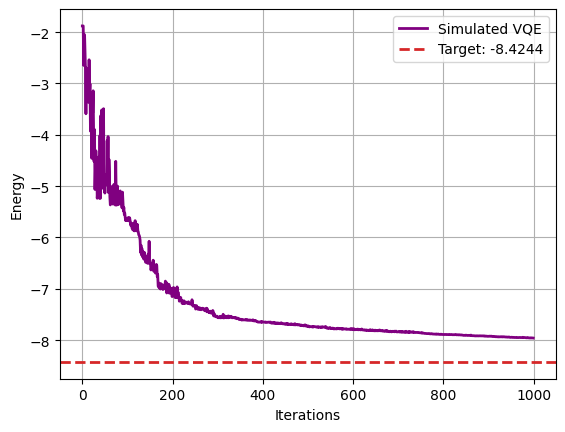

In [89]:
plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [90]:
from qiskit.circuit import Gate
class ParticleSym(Gate):
    def __init__(self,params,rev = True,label = None):
        
        self._rev = rev
        self._params = list(params)
        
        if self._rev:
            self._params[1] = 0
        super().__init__("A",2,self._params)
    
    def _define(self):
        q = QuantumRegister(2, "q")
        circ = QuantumCircuit(q,name = self.name)
        p = self._params[1]+np.pi
        t = self._params[0]+np.pi/2
        circ.cx(1,0)
        '''theta = 2*self._params[0]
        lam = self._params[1]+np.pi
        phi = -self._params[1]
        circ.cu(theta,phi,lam,0,0,1)
        '''
        circ.rz(-p,1)
        circ.ry(-t,1)
        circ.cx(0,1)
        circ.ry(t,1)
        circ.rz(p,1)
        circ.cx(1,0)
        self.definition = circ

In [64]:
from math import factorial 
from qiskit.circuit import ParameterVector
from qiskit.circuit import QuantumRegister

def comb(n,m):
    return factorial(n)//(factorial(n-m)*factorial(m))

mapping = [(i,(i+1)%N) for i in range(N)]+ [(i,(i+2)%N) for i in range(N)]

def dimer(circ,r=1):
    a2 = []
    for i in range(len(mapping)):
        a2.append(ParameterVector("ß"+str(i)+str(r),2))

    for i in range(len(mapping)):
        circ.append(ParticleSym(a2[i]),mapping[i]) 

In [91]:
def hopintans(circ,reps = 3):
    for r in range(reps):
        hopping(circ,r)
        interaction(circ,r)
        dimer(circ,r)

In [92]:
ans2 = QuantumCircuit(N)
start2(ans2)
#dimer(ans2)
hopint(ans2,reps = 2)
ans2.draw(style = "mpl")

┌───┐ ░ ┌──────────────┐                                                »
q_0: ┤ X ├─░─┤0             ├────────────────────────────────────────────────»
     └───┘ ░ │  A(ß01[0],0) │┌──────────────┐                                »
q_1: ──────░─┤1             ├┤0             ├────────────────────────────────»
     ┌───┐ ░ └──────────────┘│  A(ß11[0],0) │┌──────────────┐                »
q_2: ┤ X ├─░─────────────────┤1             ├┤0             ├────────────────»
     └───┘ ░                 └──────────────┘│  A(ß21[0],0) │┌──────────────┐»
q_3: ──────░─────────────────────────────────┤1             ├┤0             ├»
           ░                                 └──────────────┘│  A(ß31[0],0) │»
q_4: ──────░─────────────────────────────────────────────────┤1             ├»
     ┌───┐ ░                                                 └──────────────┘»
q_5: ┤ X ├─░─────────────────────────────────────────────────────────────────»
     └───┘ ░                                                                 »
q_6: ──────░─────────────────────────────────────────────────────────────────»
     ┌───┐ ░                                                                 »
q_7: ┤ X ├─░─────────────────────────────────────────────────────────────────»
     └───┘ ░                                                                 »
«                                                      ┌──────────────┐»
«q_0: ─────────────────────────────────────────────────┤1             ├»
«     ┌──────────────┐                                 │              │»
«q_1: ┤0             ├─────────────────────────────────┤              ├»
«     │              │                                 │              │»
«q_2: ┤  A(ß91[0],0) ├─────────────────────────────────┤              ├»
«     │              │                ┌───────────────┐│              │»
«q_3: ┤1             ├────────────────┤0              ├┤              ├»
«     ├──────────────┤                │               ││  A(ß71[0],0) │»
«q_4: ┤0             ├────────────────┤  A(ß111[0],0) ├┤              ├»
«     │  A(ß41[0],0) │┌──────────────┐│               ││              │»
«q_5: ┤1             ├┤0             ├┤1              ├┤              ├»
«     └──────────────┘│  A(ß51[0],0) │└┬──────────────┤│              │»
«q_6: ────────────────┤1             ├─┤0             ├┤              ├»
«                     └──────────────┘ │  A(ß61[0],0) ││              │»
«q_7: ─────────────────────────────────┤1             ├┤0             ├»
«                                      └──────────────┘└──────────────┘»
«      ┌──────────────┐                                                   »
«q_0: ─┤0             ├───────────────────────────────────────────────────»
«      │              │                 ┌───────────────┐                 »
«q_1: ─┤  A(ß81[0],0) ├─────────────────┤1              ├────────■────────»
«      │              │┌───────────────┐│               │        │        »
«q_2: ─┤1             ├┤0              ├┤               ├────────■────────»
«      └──────────────┘│               ││               │                 »
«q_3: ─────────────────┤  A(ß101[0],0) ├┤               ├─────────────────»
«                      │               ││               │┌───────────────┐»
«q_4: ─────────────────┤1              ├┤  A(ß151[0],0) ├┤0              ├»
«     ┌───────────────┐└───────────────┘│               ││               │»
«q_5: ┤0              ├─────────────────┤               ├┤  A(ß121[0],0) ├»
«     │               │                 │               ││               │»
«q_6: ┤  A(ß131[0],0) ├─────────────────┤               ├┤1              ├»
«     │               │                 │               │└───────────────┘»
«q_7: ┤1              ├─────────────────┤0              ├─────────────────»
«     └───────────────┘                 └───────────────┘                 »
«     ┌───────────────┐┌────────┐                                             »
«q_0: ┤1              ├┤0       ├─■──────────────

In [97]:
sampler = Sampler()
param_count = ans2.num_parameters
initial_point = np.random.random(param_count)*np.pi
fidelity = QNSPSA.get_fidelity(ans2, sampler = sampler)
optimizer = QNSPSA(fidelity,maxiter = 100)
#optimizer = SPSA(maxiter = 1000)
intermediate_info = []
params_info = []
vqe2 = VQE(est,ans2,optimizer,callback = callback,initial_point = initial_point)
eigen = vqe2.compute_minimum_eigenvalue(qubit_jw_op).eigenvalue
print(eigen)

-5.247867962098924


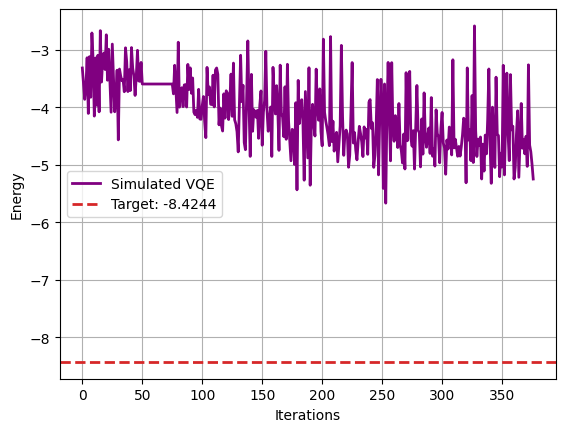

In [98]:
plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [232]:
from qiskit.quantum_info import PauliList,Pauli,SparsePauliOp



def TotalSpin(num):
    pl = []
    for i in range(num):
        I_beg = "I"*i
        I_beg += "Z"
        I_beg += "I"*(num-i-1)
        pl.append(I_beg)

    p_list = PauliList(pl)
    sp_list = SparsePauliOp(p_list)
    tSpin = PauliSumOp(sp_list)
    return tSpin
print(TotalSpin(N))

1.0 * ZIIIIIIIIIII
+ 1.0 * IZIIIIIIIIII
+ 1.0 * IIZIIIIIIIII
+ 1.0 * IIIZIIIIIIII
+ 1.0 * IIIIZIIIIIII
+ 1.0 * IIIIIZIIIIII
+ 1.0 * IIIIIIZIIIII
+ 1.0 * IIIIIIIZIIII
+ 1.0 * IIIIIIIIZIII
+ 1.0 * IIIIIIIIIZII
+ 1.0 * IIIIIIIIIIZI
+ 1.0 * IIIIIIIIIIIZ


/var/folders/n_/1wl7_2l52y3g1_82hvk9hw3h0000gn/T/ipykernel_11925/1837032028.py:15: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  tSpin = PauliSumOp(sp_list)


# Add Symmetry Penalty

## Notes:
Does not work very well. Slows things down.

In [240]:
from qiskit.algorithms import MinimumEigensolver, VQEResult
from qiskit.opflow import (
    CircuitSampler,
    CircuitStateFn,
    ExpectationBase,
    ExpectationFactory,
    ListOp,
    OperatorBase,
    PauliSumOp,
    StateFn,
)
from typing import Union, List, Dict

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None, initial_point = None, sym = True):
        self._estimator = estimator
        self.ansatz = circuit
        self._optimizer = optimizer
        self._callback = callback
        self._initial_point = initial_point
        #backend = Aer.get_backend("statevector_simulator")
        #self._circuit_sampler = CircuitSampler(
        #    backend
        #)
        self._sym = sym
     
    '''def _get_eigenstate(self, optimal_parameters) -> Union[List[float], Dict[str, int]]:
        """Get the simulation outcome of the ansatz, provided with parameters."""
        optimal_circuit = self.ansatz.bind_parameters(optimal_parameters)
        state_fn = self._circuit_sampler.convert(StateFn(optimal_circuit)).eval()
        state = state_fn.primitive.data  # VectorStateFn -> Statevector -> np.array
        return state'''
    
    
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):    
        num = 0
        # Define objective function to classically minimize over
        def objective(x, shots = None):
            #adjust number of shots
            # Execute job with estimator primitive
            if shots is not None:
                shots = int(shots)
                self._estimator.set_options(shots = shots)
            else:
                self._estimator.set_options(shots = 1024)
            job = self._estimator.run([self.ansatz], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            if self._sym:
                spinop = TotalSpin(self.ansatz.num_qubits)
                job_sym = self._estimator.run([self.ansatz], [spinop], [x])
                est_result_sym = job_sym.result()
                value_sym = est_result_sym.values[0]
                value += 0.5*(value_sym)**2
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        if self._initial_point is None:  
            x0 = np.pi/4 * np.random.rand(self.ansatz.num_parameters)
        else:
            x0 = self._initial_point
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nit
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        result.eigenstate = None #self._get_eigenstate(result.optimal_parameters)
        
        return result

In [246]:
param_count = ans2.num_parameters
initial_point = np.random.random(param_count)*np.pi
#fidelity = QNSPSA.get_fidelity(ans2, sampler = sampler)
#optimizer = QNSPSA(fidelity,maxiter = 100)
optimizer = SPSA(maxiter = 1000)
intermediate_info = []
def callback(value):
        intermediate_info.append(value)
vqe3 = CustomVQE(est,ans2,optimizer,callback = callback,initial_point = initial_point,sym = True)
eigen = vqe3.compute_minimum_eigenvalue(qubit_jw_op).eigenvalue
print(eigen)

/var/folders/n_/1wl7_2l52y3g1_82hvk9hw3h0000gn/T/ipykernel_11925/1837032028.py:15: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  tSpin = PauliSumOp(sp_list)
/var/folders/n_/1wl7_2l52y3g1_82hvk9hw3h0000gn/T/ipykernel_11925/1837032028.py:15: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  tSpin = PauliSumOp(sp_list)
/var/folders/n_/1wl7_2l52y3g1_82hvk9hw3h0000gn/T/ipykernel_11925/1837032028.py:15: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier th

-8.991006856344724


/var/folders/n_/1wl7_2l52y3g1_82hvk9hw3h0000gn/T/ipykernel_11925/3666946855.py:74: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQEResult`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQEResult``. See https://qisk.it/algo_migration for a migration guide.
  result = VQEResult()


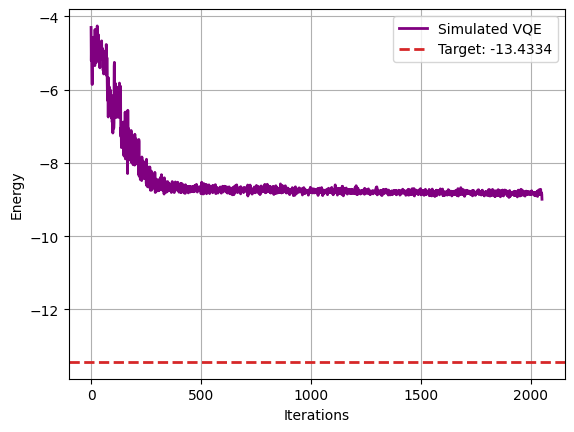

In [247]:
plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()